## Deep Neural Network MNIST

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [3]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

## Data

In [5]:
transform = transforms.Compose([transforms.Resize((32, 32)),
                               transforms.ToTensor(),
                               transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
transform_train = transforms.Compose([transforms.Resize((32, 32)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
                                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                               transforms.ToTensor(),
                               transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])


training_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
validation_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=100, shuffle=False)

0it [00:00, ?it/s]

170500096it [00:06, 26945613.82it/s]                               


Files already downloaded and verified


In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
def im_convert(tensor):
    image = tensor.cpu().clone().detach().numpy() #.cpu() is needed in the testing part
    image = image.transpose(1,2,0)
    image = image*np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1) #values smaller than 0 will be converted to 0 while the ones larger than 1 will be 1
    return image

In [0]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

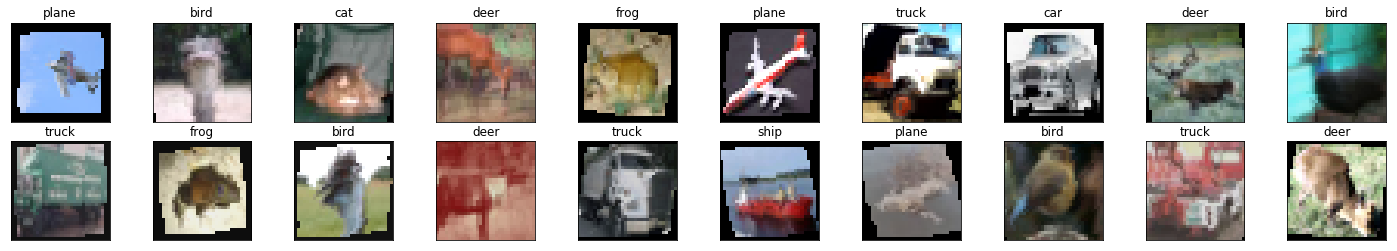

In [12]:
dataiter = iter(training_loader) #iterable
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in range(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks = [], yticks=[]) #set ticks as empty
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[idx].item()])

## Model

In [0]:
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1) #input_channels, number of output channels(filters), kernel size, stride
    self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
    self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
    self.fc1 = nn.Linear(4*4*64, 500) #fully connected layer(dimension: 32 > 16 > 8 > 4)
    self.dropout1 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(500, 10)
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2) #kernel size = 2, stride = 2
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x, 2, 2)
    x = x.view(-1, 4*4*64)
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    x = self.fc2(x)
    return x  

In [0]:
model = LeNet().to(device)

In [36]:
model

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [38]:
epochs = 25
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):
  print (e, "/", epochs)
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for inputs, labels in training_loader: #BATCH GRADIENT DESCENT
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)
  else:
    with torch.no_grad():
      for val_inputs, val_labels in validation_loader:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)
        
        _, val_preds = torch.max(val_outputs, 1)
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)
    epoch_loss = running_loss/len(training_loader)
    epoch_acc = running_corrects.float()/len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_epoch_acc = val_running_corrects.float()/len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
        

0 / 25
1 / 25
2 / 25
3 / 25
4 / 25
5 / 25
6 / 25
7 / 25
8 / 25
9 / 25
10 / 25
11 / 25
12 / 25
13 / 25
14 / 25
15 / 25
16 / 25
17 / 25
18 / 25
19 / 25
20 / 25
21 / 25
22 / 25
23 / 25
24 / 25


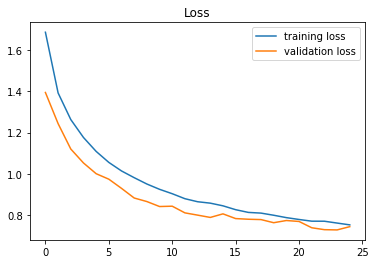

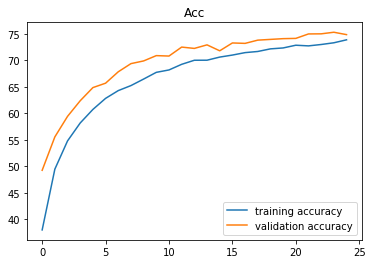

In [39]:
plt.title('Loss')
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()
plt.show()

plt.title('Acc')
plt.plot(running_corrects_history, label='training accuracy')
plt.plot(val_running_corrects_history, label='validation accuracy')
plt.legend()
plt.show()

In [0]:
import PIL.ImageOps

In [0]:
import requests
from PIL import Image

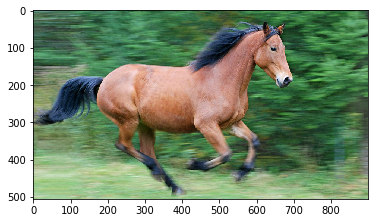

In [66]:
url = 'https://imagesvc.meredithcorp.io/v3/mm/image?url=https%3A%2F%2Fimg1.southernliving.timeinc.net%2Fsites%2Fdefault%2Ffiles%2Fstyles%2F4_3_horizontal_inbody_900x506%2Fpublic%2Fimage%2F2016%2F10%2Fmain%2Ftan_horse_running-135796262.jpg%3Fitok%3DaRaET5Ul&q=85'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

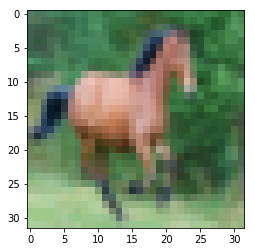

In [67]:
#img = PIL.ImageOps.invert(img) #convert to black background and white forground
#img = img.convert('1') #binary image - black white image
img = transform(img)
plt.imshow(im_convert(img))

In [68]:
img[0].shape

torch.Size([32, 32])

In [69]:
image = img.to(device)
print (image.shape)
image = image.unsqueeze(0)#.unsqueeze(0) #into shape of (batch_size, channel, width, height)
print (image.shape)
output = model.forward(image) #it is equivalent to model(img)
_, pred = torch.max(output, 1)
print (classes[pred.item()])

torch.Size([3, 32, 32])
torch.Size([1, 3, 32, 32])
horse


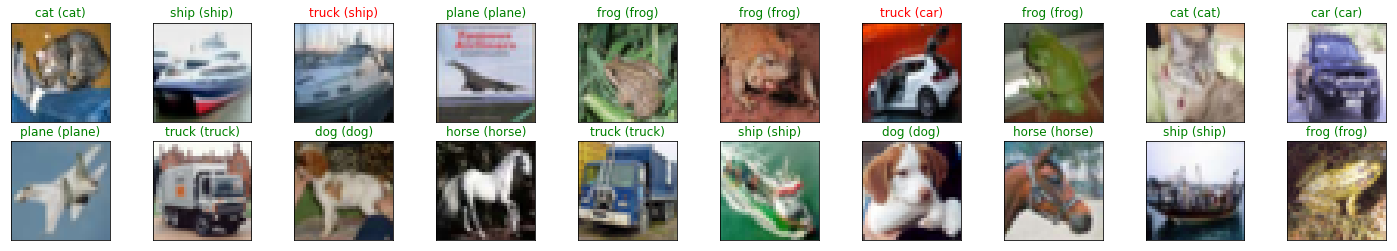

In [71]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device) #convert tensor to cuda tensor type
labels = labels.to(device)
output = model(images)
_, preds =torch.max(output, 1)

fig = plt.figure(figsize = (25, 4))

for idx in range(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks = [], yticks = [])
  plt.imshow(im_convert(images[idx]))
  ax.set_title('{} ({})'.format(classes[preds[idx].item()], classes[labels[idx].item()]), color = 'green' if preds[idx]==labels[idx] else "red")